### How to use this notebook
The data used in this notebook is not public. Contact Tamas to get an API key. Then create a python file in the same folder as this notebook, and name that file *girder_apikey_read.py*. Add only one line to that file that looks like this, just a different key string:
`girder_apikey_read="UjNzqutrfBwuk4t39VlJnJs4t3EZ6i7"`

In [71]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

this_notebook_name = "ResUNet-BreastTumorSegmentationStudy"

# This should be the only parameter to update for your local environment

local_data_folder = r"C:\Data\BreastTumorSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

import numpy as np
ultrasound_size = 128
num_classes = 2
num_epochs = 1
batch_size = 16
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 8
class_weights = np.array([0.1, 0.9])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]
limit_validation_rounds = 1


# limit_validation_rounds = 1

Save timestamp: 2020-01-15_12-13-55


In [72]:
import os
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import ultrasound_batch_generator as generator
import sagittal_spine_segmentation_unet as unet
import ResUNet_Model as resunet
import evaluation_metrics


from girder_apikey_read import girder_apikey_read

In [73]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5e1bae9ed9e6a3be02d013bc", #003
    "5dfbc687d9e6a3be02d01343", #004-v02
    "5e1cb476d9e6a3be02d01425", #005-v02
    "5e1cb685d9e6a3be02d01434", #006-v02
    "5e1cb84ed9e6a3be02d0143a", #007-v02
    "5e14cef4d9e6a3be02d01377", #008-v02
    "5e14cef4d9e6a3be02d0137a", #009-v02
    "5e1cba04d9e6a3be02d01440", #010-v02
    "5e1cbd21d9e6a3be02d01446", #011
    "5e1cbf54d9e6a3be02d0144c", #012
    "5e1cc395d9e6a3be02d01452", #013
    "5e1cc4fcd9e6a3be02d01458", #014
    "5e14cef4d9e6a3be02d0137d", #015
    "5e1cc907d9e6a3be02d0145e", #016
    "5e1cca85d9e6a3be02d01464", #018
    "5e1ccb5dd9e6a3be02d0146a", #019
    "5e1cb5ced9e6a3be02d0142b", #020
    "5e16028cd9e6a3be02d01386", #021
    "5e163f18d9e6a3be02d01392", #022
    "5e163f0dd9e6a3be02d0138c", #023
    "5e163f22d9e6a3be02d01398", #024
    "5e163f2ad9e6a3be02d0139e", #025
    "5e1c99f1d9e6a3be02d01401", #026
    "5e1c99f1d9e6a3be02d01404", #027
    "5e1c99f2d9e6a3be02d01407", #028
    "5e1c99f2d9e6a3be02d0140a", #029
    "5e1c99f3d9e6a3be02d0140d", #030
    "5e1c99f3d9e6a3be02d01410", #031
    "5e1c99f4d9e6a3be02d01413", #032
    "5e1c99f5d9e6a3be02d01416", #035
    "5e1c99f5d9e6a3be02d01419", #037
    "5e1c99f6d9e6a3be02d0141c", #038
    "5e1c99f6d9e6a3be02d0141f", #039
    "5df79d49d9e6a3be02d01332", #test
]

training_ultrasound_filenames = [
    "ultrasound-003-v02.npy",
    "ultrasound-004-v02.npy",
    "ultrasound-005-v02.npy",
    "ultrasound-006-v02.npy",
    "ultrasound-007-v02.npy",
    "ultrasound-008-v02.npy",
    "ultrasound-009-v02.npy",
    "ultrasound-010-v02.npy",
    "ultrasound-011.npy",
    "ultrasound-012.npy",
    "ultrasound-013.npy",
    "ultrasound-014.npy",
    "ultrasound-015.npy",
    "ultrasound-016.npy",
    "ultrasound-018.npy",
    "ultrasound-019.npy",
    "ultrasound-020.npy",
    "ultrasound-021.npy",
    "ultrasound-022.npy",
    "ultrasound-023.npy",
    "ultrasound-024.npy",
    "ultrasound-025.npy",
    "ultrasound-026.npy",
    "ultrasound-027.npy",
    "ultrasound-028.npy",
    "ultrasound-029.npy",
    "ultrasound-030.npy",
    "ultrasound-031.npy",
    "ultrasound-032.npy",
    "ultrasound-035.npy",
    "ultrasound-037.npy",
    "ultrasound-038.npy",
    "ultrasound-039.npy",
    "ultrasound-test.npy"
]

training_segmentation_ids = [
    "5e1bae9ed9e6a3be02d013b9", #003
    "5dfbc686d9e6a3be02d01340", #004-v02
    "5e1cb475d9e6a3be02d01422", #005-v02
    "5e1cb684d9e6a3be02d01431", #006-v02
    "5e1cb84dd9e6a3be02d01437", #007-v02
    "5e14cef3d9e6a3be02d0136e", #008-v02
    "5e14cef3d9e6a3be02d01371", #009-v02
    "5e1cba04d9e6a3be02d0143d", #010-v02
    "5e1cbd20d9e6a3be02d01443", #011
    "5e1cbf54d9e6a3be02d01449", #012
    "5e1cc395d9e6a3be02d0144f", #013
    "5e1cc4fcd9e6a3be02d01455", #014
    "5e14cef3d9e6a3be02d01374", #015
    "5e1cc906d9e6a3be02d0145b", #016
    "5e1cca84d9e6a3be02d01461", #018
    "5e1ccb5cd9e6a3be02d01467", #019
    "5e1cb5ced9e6a3be02d01428", #020
    "5e16028bd9e6a3be02d01383", #021
    "5e163f17d9e6a3be02d0138f", #022
    "5e163f0cd9e6a3be02d01389", #023
    "5e163f21d9e6a3be02d01395", #024
    "5e163f29d9e6a3be02d0139b", #025
    "5e1c99edd9e6a3be02d013e0", #026
    "5e1c99edd9e6a3be02d013e3", #027
    "5e1c99edd9e6a3be02d013e6", #028
    "5e1c99eed9e6a3be02d013e9", #029
    "5e1c99eed9e6a3be02d013ec", #030
    "5e1c99eed9e6a3be02d013ef", #031
    "5e1c99efd9e6a3be02d013f2", #032
    "5e1c99efd9e6a3be02d013f5", #035
    "5e1c99efd9e6a3be02d013f8", #037
    "5e1c99efd9e6a3be02d013fb", #038
    "5e1c99f0d9e6a3be02d013fe", #039
    "5df79d41d9e6a3be02d0131a", #test    
]

training_segmentation_filenames = [
    "segmentation-003-v02.npy",
    "segmentation-004-v02.npy",
    "segmentation-005-v02.npy",
    "segmentation-006-v02.npy",
    "segmentation-007-v02.npy",
    "segmentation-008-v02.npy",
    "segmentation-009-v02.npy",
    "segmentation-010-v02.npy",
    "segmentation-011.npy",
    "segmentation-012.npy",
    "segmentation-013.npy",
    "segmentation-014.npy",
    "segmentation-015.npy",
    "segmentation-016.npy",
    "segmentation-018.npy",
    "segmentation-019.npy",
    "segmentation-020.npy",
    "segmentation-021.npy",
    "segmentation-022.npy",
    "segmentation-023.npy",
    "segmentation-024.npy",
    "segmentation-025.npy",
    "segmentation-026.npy",
    "segmentation-027.npy",
    "segmentation-028.npy",
    "segmentation-029.npy",
    "segmentation-030.npy",
    "segmentation-031.npy",
    "segmentation-032.npy",
    "segmentation-035.npy",
    "segmentation-037.npy",
    "segmentation-038.npy",
    "segmentation-039.npy",
    "segmentation-test.npy"
]

In [74]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

In [75]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

# Setting up number of validation rounds

n_files = len(training_ultrasound_ids)
if limit_validation_rounds > 0:
    num_validation_rounds = min(n_files, limit_validation_rounds)
else:
    num_validation_rounds = n_files

# Preparing progress bar

f = IntProgress(min=0, max=n_files*2)
display(f)

# Downloading files

gclient = girder_client.GirderClient(apiUrl=girder_api_url)
gclient.authenticate(apiKey=girder_apikey_read)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=68)


Total download time: 0:00:00.103868


In [76]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=68)


Total time to load from files: 0:00:00.278289


In [77]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

Num GPUs Available:  0


Timestamp for saved files: 2020-01-15_12-13-55

Training parameters
Number of epochs:    1
Step size maximum:   0.02
Step size decay:     0.01999
Batch size:          16
Regularization rate: 0.0001

Saving validation predictions in: C:\Data\BreastTumorSegmentationStudy\PredictionsValidation
Saving models in:                 C:\Data\BreastTumorSegmentationStudy\SavedModels

*** Leave-one-out round # 0

Training on 292 images, validating on 379 images...
Validation ultrasound data shape:            (379, 128, 128, 1)
Validation segmentation data shape:          (379, 128, 128, 1)
Validation segmentation data (onehot) shape: (379, 128, 128, 2)
18/18 [==============================] - 388s 22s/step - loss: 0.1412 - accuracy: 0.8869 - val_loss: 0.1361 - val_accuracy: 0.9906

Metrics at the end of training
  val_acc:       0.9905884861946106
  val loss:      0.13608333872010311
  Training time: 0:06:27.931138

Total round time:  0:07:40.486435


Total training time:   0:07:42.006374


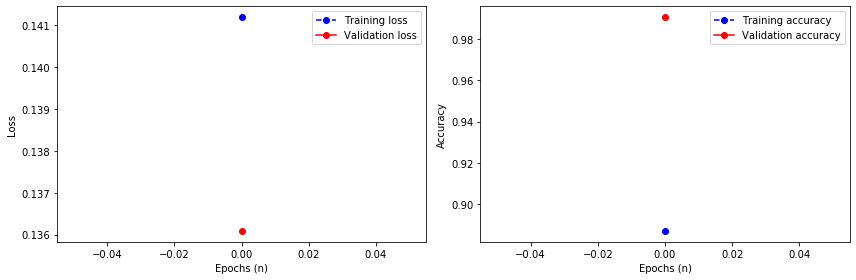

In [78]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for i in range(num_validation_rounds):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    train_segmentation_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    
    val_ultrasound_data = ultrasound_arrays[i]
    val_segmentation_data = segmentation_arrays[i]
    val_ultrasound_filename = training_ultrasound_filenames[i]
    
    for train_index in range(2):
        if train_index != i:
            train_ultrasound_data = np.concatenate((train_ultrasound_data, ultrasound_arrays[train_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data, segmentation_arrays[train_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(i))
    print("\nTraining on {} images, validating on {} images...".format(n_train, n_val))
    
    val_segmentation_data_onehot = tf.keras.utils.to_categorical(val_segmentation_data, num_classes)
    
    print("Validation ultrasound data shape:            {}".format(val_ultrasound_data.shape))
    print("Validation segmentation data shape:          {}".format(val_segmentation_data.shape))
    print("Validation segmentation data (onehot) shape: {}".format(val_segmentation_data_onehot.shape))
    
    # Create and train model
    
    model = resunet.resunet(ultrasound_size, num_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
        # loss=tf.keras.losses.categorical_crossentropy,
        loss=resunet.weighted_categorical_crossentropy(class_weights),
        metrics=["accuracy"]
    )
        
    # model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(
        training_generator,
        validation_data=(val_ultrasound_data, val_segmentation_data_onehot),
        epochs=num_epochs,
        verbose=1
    )
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("\nMetrics at the end of training")
    print("  val_acc:       {}".format(training_log.history['val_accuracy'][-1]))
    print("  val loss:      {}".format(training_log.history['val_loss'][-1]))
    # print("  val_dice:      {}".format(training_log.history['val_dice_coef'][-1]))
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['accuracy'], 'bo--')
    axes[1].plot(training_log.history['val_accuracy'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on validation data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    
    # Saving predictions for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = save_timestamp + "_prediction_" + filename_noext + ".npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    np.save(val_prediction_fullname, y_pred_val)
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(i) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    
    # Validation results
    
    vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_best_metrics[i]    = vali_metrics_dicts[vali_best_threshold_index]
    val_aurocs[i]          = vali_area
    val_best_thresholds[i] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))

In [50]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [51]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    results_df.loc[i] = [
        val_aurocs[i],
        val_best_thresholds[i],
        val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.RECALL],
        val_best_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.RECALL],
        val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore
0,0.0,0.9,0.0,0.0,0.0,1.0,0.0,1.0,0.0



Averages


Vali AUROC           0.0
Vali best thresh     0.9
Vali best TP         0.0
Vali best FP         0.0
Vali best recall     0.0
Vali best precis     1.0
Vali fuzzy recall    0.0
Vali fuzzy precis    1.0
Vali fuzzy Fscore    0.0
dtype: float64

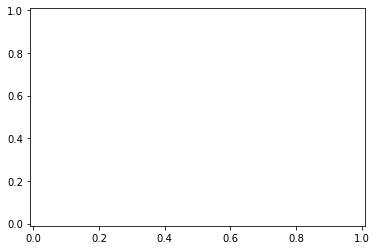

In [20]:

# Print the last ROC curve for visual verification that we catch the optimal point

n = len(roc_thresholds)

roc_x = np.zeros(n)
roc_y = np.zeros(n)

for i in range(n):
    roc_x[i] = vali_metrics_dicts[i][evaluation_metrics.FALSE_POSITIVE_RATE]
    roc_y[i] = vali_metrics_dicts[i][evaluation_metrics.SENSITIVITY]
    # print("Threshold = {0:4.2f}  False pos rate = {1:4.2f}  Sensitivity = {2:4.2f}"
    #       .format(roc_thresholds[i], roc_x[i], roc_y[i]))

    
plt.figure()
plt.ylim(-0.01, 1.01)
plt.xlim(-0.01, 1.01)
plt.plot(roc_x, roc_y, color='darkred', lw=2)

In [20]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedResults/BreastTumorSegmentationStudy_2020-01-14_13-08-15.csv


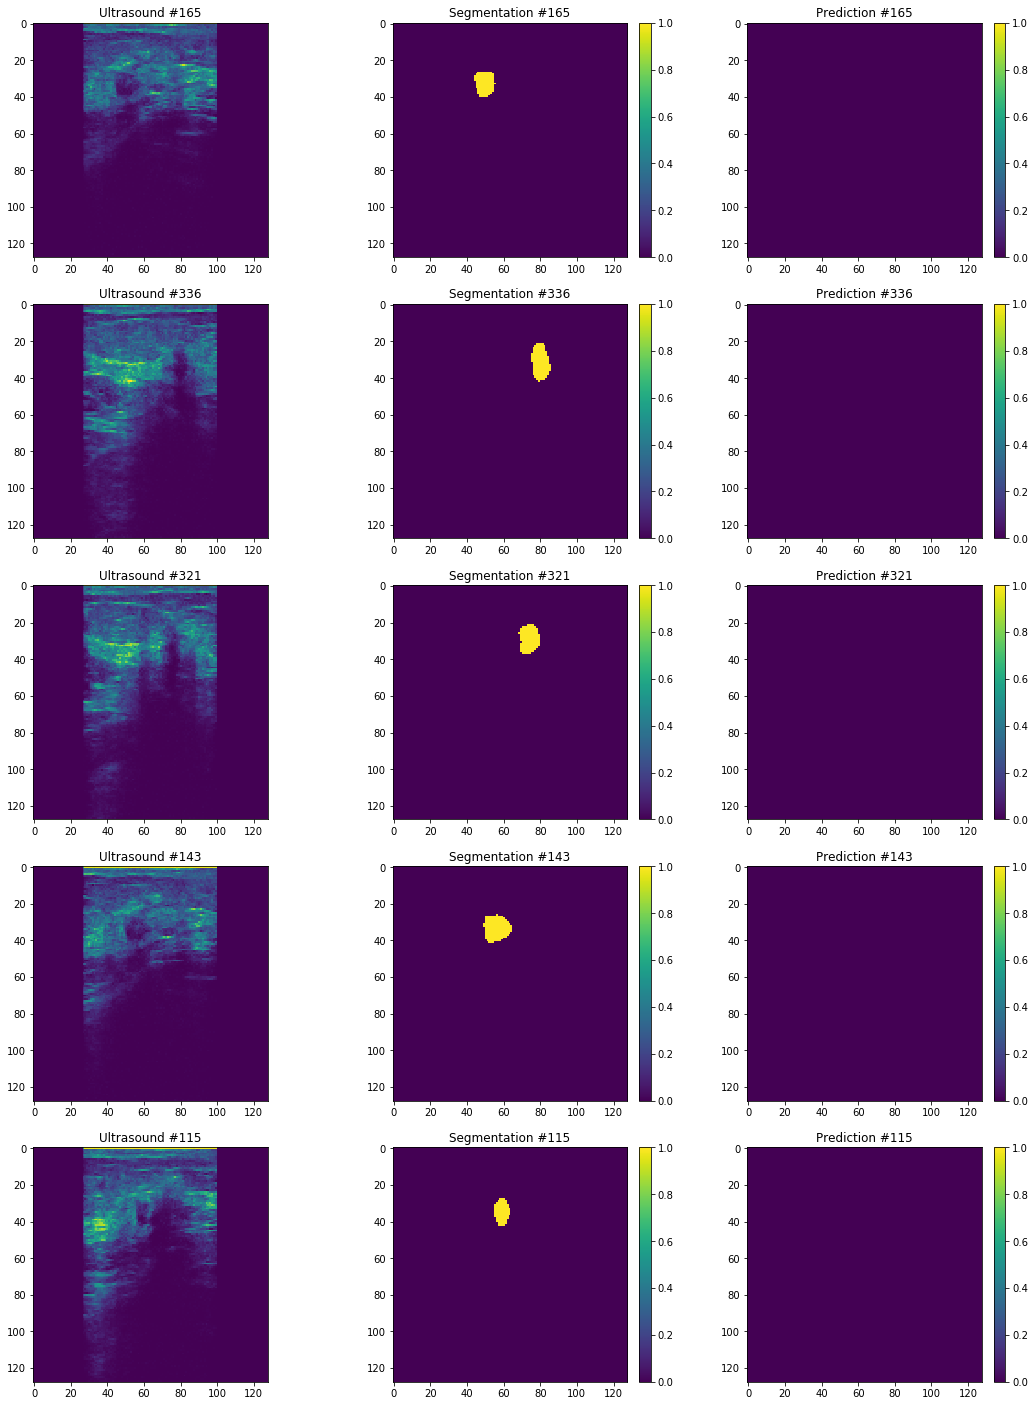

In [79]:
# Display sample results

num_vali = val_ultrasound_data.shape[0]
num_show = 5

indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)

# Uncomment for comparing the same images
# sample_indices = [105, 195, 391, 133, 142]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(np.flipud(val_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(np.flipud(val_segmentation_data_onehot[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(np.flipud(y_pred_val[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [21]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [22]:

# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedNotebooks/BreastTumorSegmentationStudy_2020-01-14_13-08-15.html


In [80]:
input_size = 128
num_layers = int(np.floor(np.log2(input_size)))
down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
down_filter_numbers = np.zeros([num_layers], dtype=int)
up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
up_filter_numbers = np.zeros([num_layers], dtype=int)

In [83]:
for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int((layer_index + 1) * filter_multiplier + num_classes)
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int((num_layers - layer_index - 1) * filter_multiplier + num_classes)

In [86]:
up_filter_numbers

array([50, 42, 34, 26, 18, 10,  2])